# CNN GE Exploration
**Date: 12-10-2020**

### Resources/Guides
- https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/
- https://github.com/youngsoul/pyimagesearch-regression-with-keras
- https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
- https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import copy 
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import glob
import cv2
import os
from PIL import Image
import glob
from os import listdir
from os.path import isfile, join
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------------------------------------------------------------------------------------------

## Functions

In [4]:
def create_mlp(dim, regress=False):
    """
    create a multi-layer perceptron architeture with: dim-8-4
    :param dim:
    :param regress:
    :return:
    """
    #define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation='relu'))
    model.add(Dense(4, activation='relu'))

    # check to see if the regression node should be added
    # If we are performing regression, we add a Dense layer containing a
    # single neuron with a linear activation function (below).
    # Typically we use ReLU-based activations, but since we are performing
    # regression we need a linear activation.
    if regress:
        model.add(Dense(1, activation="linear"))

    return model

In [5]:
def create_cnn(width, height, depth, filters=(16,32,64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # flatten the volume, then FC => RELU => BN => DROPOUT
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)

        # apply another FC layer, this one to match the number of nodes
        # coming out of the MLP
        x = Dense(4)(x)
        x = Activation("relu")(x)

        # check to see if the regression node should be added
        if regress:
            x = Dense(1, activation="linear")(x)

        # construct the CNN
        model = Model(inputs, x)

        # return the CNN
        return model

In [9]:
def load_images(df, paths_list, path):
    """
    For each index, read the set of 4 images, and create a 4x4 montage of all separate images
    to create a single image for each house to train o.
    :param df:
    :param inputPath:
    :return:
    """
    # initialize our images array
    images = []
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")
    for housePath in paths_list:
      image = cv2.imread( path +'/' + housePath)
      inputImages.append(image)

    images = inputImages # I changed the code here

    # return our set of images
    return np.array(images)

----------------------------------------------------------------------------------------------------------------

In [10]:
# over here we are labelling the path to access the csv data on the output values (dimensions)

path_162 = "/content/drive/MyDrive/GE_data_x/GE_dataset/cnn_hassan/v1_cnn/162_cnn_hassan_v3.csv"
path_182 = '/content/drive/MyDrive/GE_data_x/GE_dataset/cnn_hassan/182_cnn_hassan_relevant_frames.csv'
width_162_df = pd.read_csv(path_162)
width_182_df = pd.read_csv(path_182)[['tdms_index', 'Width']].rename(columns={"tdms_index": "Frame_Index"})

In [11]:
# data cleaning -  getting the width data
frames = [width_162_df, width_182_df]
width_df = width_162_df
width_df.head(1)

,Frame_Index,Width
0,639002,127.088203


In [12]:
# getting only the relevant index values that are within the width csv
index_vals = []
for elem in width_df['Frame_Index']: index_vals.append(elem)

In [13]:
type(index_vals[0])

int

In [14]:
def dirs_func(new_path):
  '''This function gets all of the file names within a folder based on the path'''
  dirs = os.listdir(new_path)
  # This would print all the files and directories
  onlyfiles = []
  for file in dirs:
    onlyfiles.append(file)
  return onlyfiles

In [19]:
# Open a file
new_path1 = "/content/drive/MyDrive/GE_data_x/GE_dataset/frames/frames_162_v3"
onlyfiles1 = dirs_func(new_path1)

In [20]:
# uncomment to run for 182

# new_path2 = "/content/drive/MyDrive/GE_data_x/frames_182_png"
# onlyfiles2 = dirs_func(new_path2)

In [21]:
onlyfiles = onlyfiles1 #+ onlyfiles2 # only uncomment if adding 182

In [24]:
# over here we are appending relevant images that correspond to the above relevant frame index values

relevant_images, rel_vals = [], [] # we will join using relevant vals
for file_name in onlyfiles:
    try:
        try:
          int_val = int(file_name[14:20])#int(file_name[6:12])
        except Exception: pass
        # try:
        #   int_val = int(file_name[14:20])
        # except Exception: pass
        if int_val in index_vals:
            relevant_images.append(file_name)
            rel_vals.append(int_val)
    except Exception: pass

In [25]:
# lets check and make sure we are receiving an output and how much.
len(relevant_images)

17230

In [31]:
# the num_pics is equivalent to how much data is fed into the CNeural Network

num_pics = 500 # this value can be changed.
image_name_list = []
for img_name in relevant_images[:num_pics]:
    try:
      for filename in glob.glob(new_path1 + '/' + str(img_name)):
          image_name_list.append(img_name)
    except Exception: pass
    # try:
    #   for filename in glob.glob(new_path2 + '/' + str(img_name)):
    #       image_name_list.append(img_name)
    except Exception: pass

In [32]:
# double check to make sure len does not change after appending file names
len(image_name_list)

500

In [35]:
# creating a df
d1 = {'Frame_Index': rel_vals[:num_pics], 'image_names.png': image_name_list}
df2 = pd.DataFrame(data=d1)

In [36]:
# path is defined above
df = width_df

In [37]:
# using deepcopy to deep copy
left = copy.deepcopy(df)
right = copy.deepcopy(df2)

In [38]:
# merging a df
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
result = pd.merge(left.reset_index(), right.reset_index(),on=['Frame_Index'], how='inner')

In [39]:
#visualize result df
result.head(3)

,index_x,Frame_Index,Width,index_y,image_names.png
0,2640,643115,136.713196,0,video161_frame643115.png
1,2641,643116,136.713196,1,video161_frame643116.png
2,2642,643117,136.713196,2,video161_frame643117.png


---------------------------------------------------------------------------------------------------------------------

## Running the CNN

In [46]:
# this function loads images into the CNN
first_images = load_images(result, result['image_names.png'], new_path1)

In [47]:
images = first_images # creating a new variable

In [48]:
# ensure the shape is still correct
images.shape

(500, 80, 80, 3)

In [49]:
# divide by 255 to get images into ideal format
images = images / 255.0

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing

split = train_test_split(result, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [52]:
# find the largest dimension in the training set and use it to
# scale our dimensions to the range [0, 1] (will lead to better
# training and convergence)
maxDim = trainAttrX["Width"].max()
trainY = trainAttrX["Width"] / maxDim
testY = testAttrX["Width"] / maxDim

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import keras.optimizers

In [54]:
# create our Convolutional Neural Network and then compile the model
# using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our
# dimensions *predictions* and the *actual dimensions*
model = create_cnn(80, 80, 3, regress=True)
opt = keras.optimizers.Adam(lr=1e-4, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [56]:
# this is to record data before it stops in case it crashes

new_path_checkpoint = "/content/drive/MyDrive/GE_data_x/GE_dataset\cnn_hassan\cnn_training"

checkpoint = ModelCheckpoint(new_path_checkpoint+'/'+'model{epoch:08d}.h5', period=5) 


In [57]:
# train the model
print("[INFO] training model...")

# General Observation: As we increased image input we saw std increase along with the error

model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY), epochs=1000, batch_size=25, callbacks=[checkpoint])

[INFO] training model...
Epoch 1/1000
15/15 [==============================] - 0s 16ms/step - loss: 91.5288 - val_loss: 101.5098
Epoch 2/1000
15/15 [==============================] - 0s 6ms/step - loss: 70.5502 - val_loss: 104.8275
Epoch 3/1000
15/15 [==============================] - 0s 6ms/step - loss: 59.8118 - val_loss: 107.4056
Epoch 4/1000
15/15 [==============================] - 0s 6ms/step - loss: 62.3355 - val_loss: 110.2742
Epoch 5/1000
15/15 [==============================] - 0s 6ms/step - loss: 62.5201 - val_loss: 114.8059
Epoch 6/1000
15/15 [==============================] - 0s 6ms/step - loss: 61.3704 - val_loss: 118.1204
Epoch 7/1000
15/15 [==============================] - 0s 6ms/step - loss: 54.6933 - val_loss: 120.4485
Epoch 8/1000
15/15 [==============================] - 0s 6ms/step - loss: 56.6117 - val_loss: 122.4522
Epoch 9/1000
15/15 [==============================] - 0s 6ms/step - loss: 55.5525 - val_loss: 123.5056
Epoch 10/1000
15/15 [==========================

In [58]:
# make predictions on the testing data
print("[INFO] predicting widths...")
preds = model.predict(testImagesX)

[INFO] predicting widths...


In [59]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [60]:
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# use RMSE/MAPE and show errors in a historgram

In [61]:
# finally, show some statistics on our model
import locale
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. width: {}, std width: {}".format(
    result["Width"].mean(),
    result["Width"].std()))

# use RMSE/MAPE and show errors in a historgram
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. width: 161.46763672760042, std width: 7.6008818090789125
[INFO] mean: 27.16%, std: 5.18%


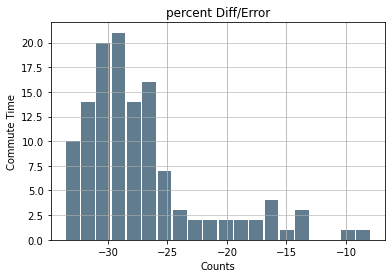

In [71]:
# plot a histogram to show percent errors
percentDiff.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('percent Diff/Error')
plt.xlabel('counts')
plt.ylabel('% error')
plt.grid(axis='y', alpha=0.75)